# Testing MPO

In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library_sorted.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Make oracles.

In [241]:
import os

dockstring_dir = f'{path}/dockstring_targets/'
files = os.listdir(dockstring_dir)
configs = sorted([f for f in files if 'conf' in f])
targets = sorted([f for f in files if 'target' in f])

idx = 11
with open(dockstring_dir + configs[idx], 'r') as f:
    config_ = f.readlines()
    config_ = [c.replace('\n', '') for c in config_]
    config_ = [c.split(' = ') for c in config_ if c]
    config_ = {c[0]: float(c[1]) for c in config_}

target = targets[idx]
name = target.split('_')[0]

config_.update({
    'size_x': 22.5,
    'size_y': 22.5,
    'size_z': 22.5,
})

from dgym.envs.oracle import DockingOracle, DGLOracle, RDKitOracle, NoisyOracle
from dgym.envs.utility import ClassicUtilityFunction

config = {
    'search_mode': 'detailed',
    'scoring': 'vina',
    'seed': 5,
    **config_
}

docking_oracle = DockingOracle(
    'CASP3 affinity',
    receptor_path=f'{path}/dockstring_targets/CASP3_target.pdbqt',
    config=config
)
log_P_oracle = RDKitOracle('MolLogP')
log_S_oracle = DGLOracle('GCN_canonical_ESOL')

# create evaluators
docking_cost_function = ClassicUtilityFunction(
    docking_oracle,
    ideal=(8, 9.5),
    acceptable=(7.7, 9.5)
)

log_P_cost_function = ClassicUtilityFunction(
    log_P_oracle,
    ideal=(0.5, 2),
    acceptable=(-0.5, 3.5)
)

# log_S_cost_function = ClassicUtilityFunction(
#     log_S_oracle,
#     ideal=(-2, 1),
#     acceptable=(-4, 1)
# )

assays = [docking_oracle, log_P_oracle]
cost_functions = [docking_cost_function, log_P_cost_function]

Instantiate designer.

In [356]:
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

Pick 5 random starting hits.

In [370]:
# select first molecule
import random
def select_molecule(deck):
    initial_index = random.randint(0, len(deck) - 1)
    initial_molecule = deck[initial_index]
    if len(initial_molecule.reactants) == 2 \
        and designer.match_reactions(initial_molecule):
        return initial_molecule
    else:
        return select_molecule(deck)

initial_molecules = [select_molecule(deck) for _ in range(5)]
initial_library = dg.MoleculeCollection(initial_molecules)
initial_library.update_annotations()
library = initial_library

Prepare MPO ranking function.

In [371]:
import numpy as np
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

def rank_molecules(costs):

    # Multi-dimensional non-dominated fusion sort
    nds, nds_ranks = NonDominatedSorting().do(
        costs, return_rank=True, only_non_dominated_front=False)
    penalty_sums = np.sum(costs, axis=1)
    fused_ranks = np.lexsort([penalty_sums, nds_ranks]) # prioritizes last column
    
    return fused_ranks.tolist()

Multi-step selection.

In [372]:
import numpy as np
from tqdm.notebook import tqdm

for molecule in library:
    molecule.update_annotations(
        {'timestep': 0, **{a.name: a(molecule) for a in assays}})

costs = np.asarray([cost(library) for cost in cost_functions]).T
ranking = rank_molecules(costs)
best = ranking[0]
print([cost(library[best]) for cost in cost_functions])
print(best)

for step in tqdm(range(1, 10)):
    
    if step % 3 == 2:
        analogs = designer.design(
            library[best], 40, strategy='grow')
    else:
        analogs = designer.design(
            library[best], 40, strategy='replace', temperature=0.1)

    # Get costs
    library += analogs
    costs = np.asarray([cost(library) for cost in cost_functions]).T
    ranking = rank_molecules(costs)
    best = ranking[0]

    for analog in analogs:
        analog.update_annotations(
            {'timestep': step, **{a.name: a(analog) for a in assays}})

    print(step, costs[best])
    print(step, best)

[11.732994146911206, 0.28766666666666707]
2


  0%|          | 0/9 [00:00<?, ?it/s]

1 [9.38948767 0.54773333]
1 18
2 [9.38948767 0.54773333]
2 18
3 [6.72110478 0.6994    ]
3 49
4 [4.12595413 1.91296561]
4 112
5 [4.12595413 1.91296561]
5 112
6 [2.81555893 1.07226025]
6 150
7 [3.03625633 0.6038    ]
7 197
8 [2.84951017 0.228     ]
8 241
9 [2.02545945 0.228     ]
9 244


# Visualizing results

Text(0.5, 1.0, 'Heavy atom count vs. pIC50')

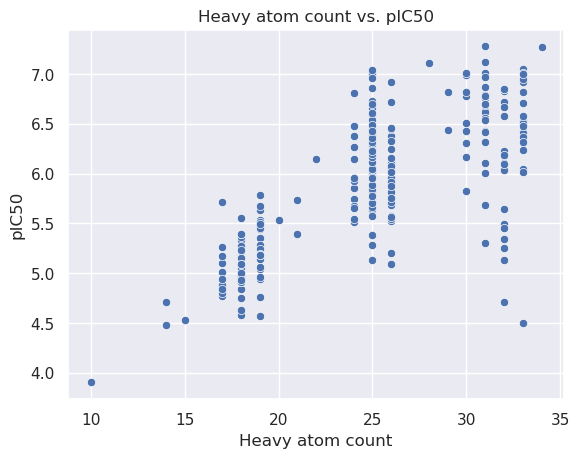

In [373]:
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem.Descriptors import HeavyAtomCount

sns.set()
sns.scatterplot(
    x=[HeavyAtomCount(m.mol) for m in library],
    y=docking_oracle(library),
)

plt.xlabel('Heavy atom count')
plt.ylabel('pIC50')
plt.title('Heavy atom count vs. pIC50')

In [374]:
records = []
docking_scores = docking_oracle(library)
logP_scores = log_P_oracle(library)
lle_scores = np.array(docking_scores) - np.array(logP_scores)
for idx, (mol, score, lle, logP) in enumerate(zip(library, docking_scores, lle_scores, logP_scores)):
    records.append(
        {'pIC50': score,
         'LLE': lle,
         'log P': logP,
         'timestep': 1 + ((idx - 5) // 20)})

import pandas as pd
df = pd.DataFrame(records)

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


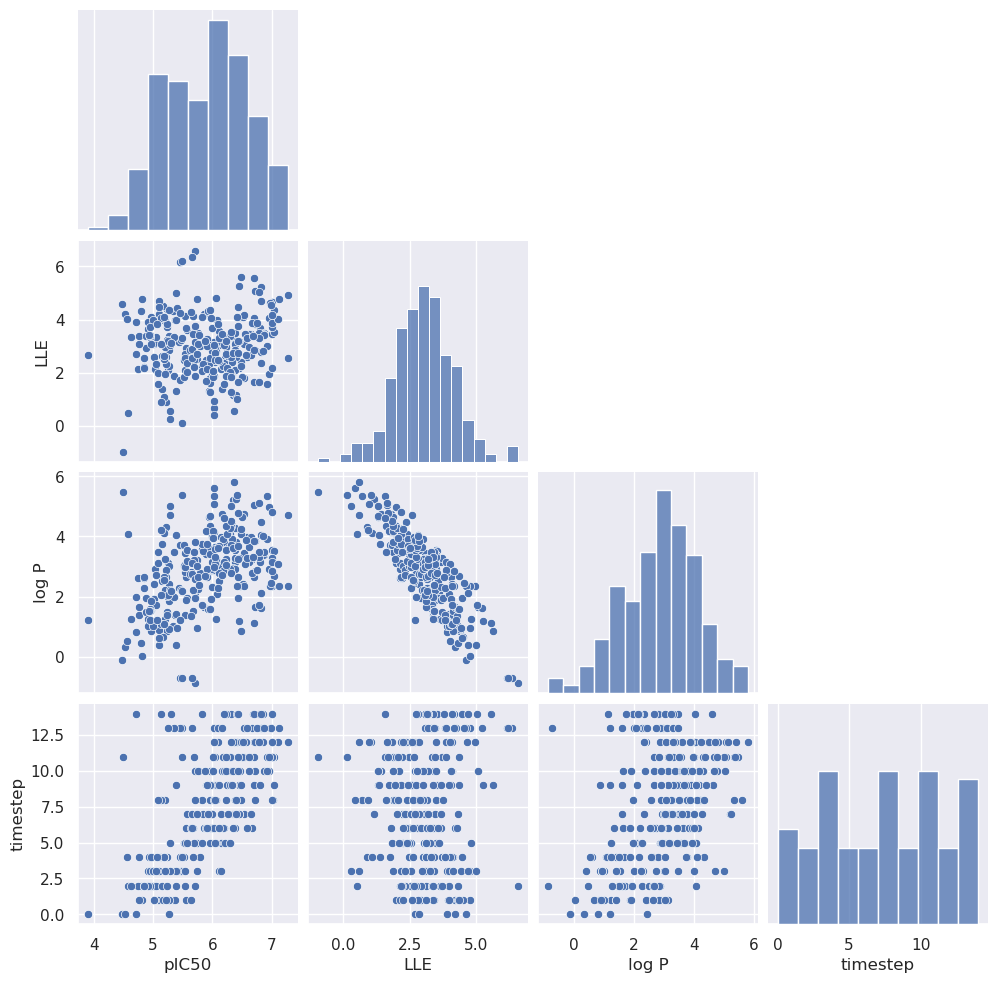

In [375]:
sns.pairplot(df, corner=True)

Text(0.5, 1.0, 'Penalizing log P drastically reduces its correlation with pIC50')

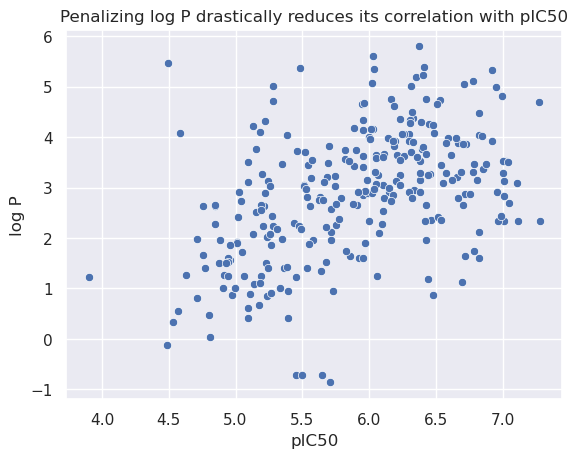

In [376]:
sns.scatterplot(df, x='pIC50', y='log P')
plt.title('Penalizing log P drastically reduces its correlation with pIC50')

## Visualizing the best across rounds

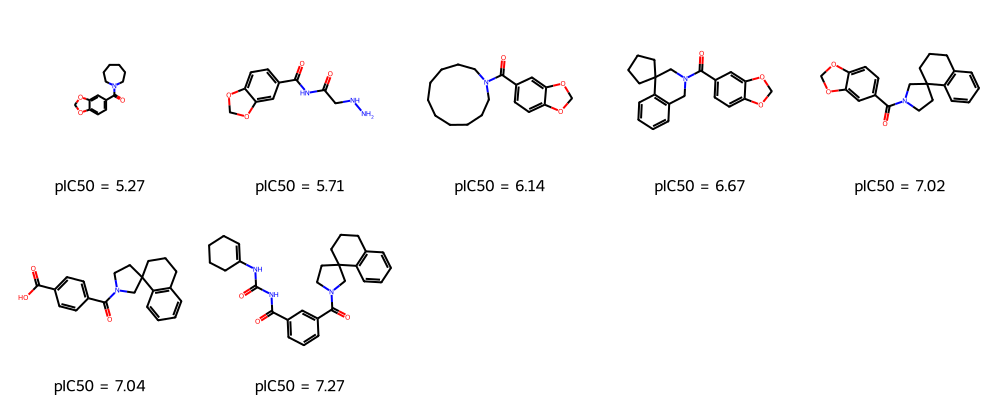

In [395]:
best_across_round = [
    library.annotations.query(f'timestep == {i}')['CASP3 affinity']
    .sort_values(na_position='first')
    .index[-1].item()
    for i in range(int(library.annotations.timestep.max()))
    if library.annotations.query(f'timestep == {i}')['CASP3 affinity'].any()
]

from rdkit.Chem.Draw import MolsToGridImage

get_affinity = lambda idx: library[idx]['CASP3 affinity'][0]
MolsToGridImage(
    [m.mol for m in library[best_across_round]],
    molsPerRow=5,
    legends=[f'pIC50 = {round(get_affinity(b), 2)}' for b in best_across_round]
)

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 15.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'New compounds synthesized each round')

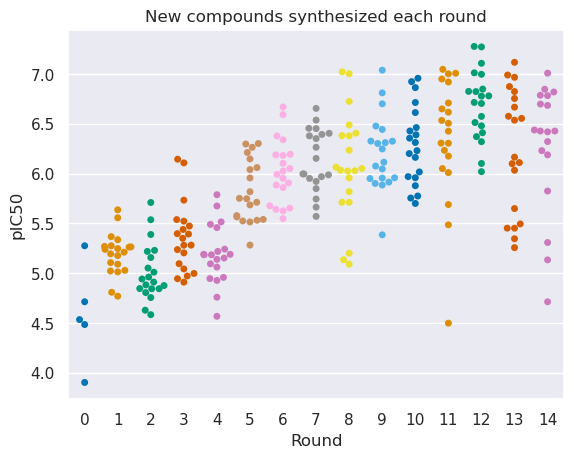

In [396]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

sns.swarmplot(
    df,
    y='pIC50',
    x='timestep',
    hue='timestep',
    palette='colorblind',
    # complementary=True,
    legend=False
)

plt.ylabel('pIC50')
plt.xlabel('Round')
plt.title('New compounds synthesized each round')

In [397]:
max_timestep = int(library.annotations.timestep.max())

records = []
for timestep, group in library.annotations.groupby('timestep'):
    for _, mol in group.iterrows():
        record = {'pIC50': mol['CASP3 affinity'][0], 'timestep': timestep}
        records.append(record)
        
        # Duplicate logic for each possible timestep
        for t in range(1, max_timestep + 1):
            if timestep < t:
                records.append({**record, 'timestep': t})

df = pd.DataFrame(records)

Text(0.5, 1.0, 'Distribution of ligand potencies across rounds')

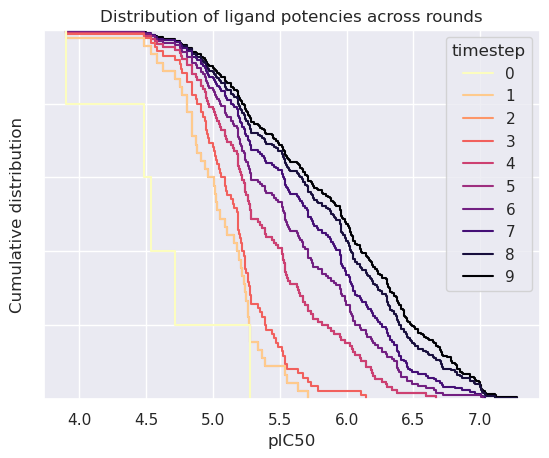

In [398]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

g = sns.ecdfplot(
    df,
    x='pIC50',
    hue='timestep',
    palette='magma_r',
    complementary=True
)

g.set(yticklabels=[])

plt.xlabel('pIC50')
plt.ylabel('Cumulative distribution')
plt.title('Distribution of ligand potencies across rounds')